<a href="https://colab.research.google.com/github/yeabwang/Human-Emotions-Detection/blob/main/Human_Emotion_detection_custom_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Multiply, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,DepthwiseConv2D,
                                     RandomContrast, Rescaling, Resizing, Reshape, ReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Load the dataset

files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

!pip install kaggle --upgrade
!pip install --upgrade pip

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes
!unzip "human-emotions-datasethes.zip" -d "/content/dataset"

In [3]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 3,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 6799 files belonging to 3 classes.


In [5]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

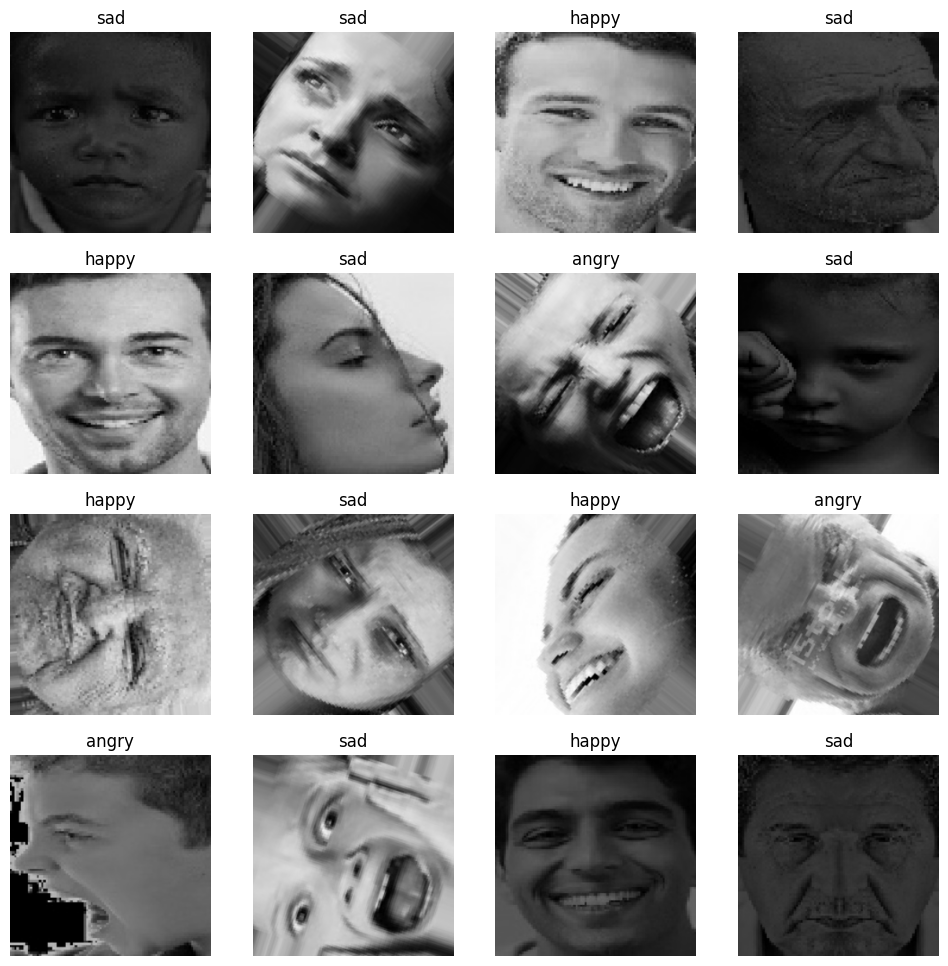

In [6]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()])
    plt.axis("off")

In [7]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = "horizontal"),
    RandomContrast(factor = 0.1),
])

In [8]:
def augment_layer(image, label):
  return augment_layers(image, training=True), label

In [9]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [10]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [11]:
# training_dataset = (train_dataset
#                     .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
#                     .prefetch(tf.data.AUTOTUNE))

# validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [12]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

Custom Sequential model


In [14]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [ ]:
# If we are dealing with int values in the dataset we can use SparseCategoricalCrossentropy()
# If we are dealing with categorical values in the datset we can use CategoricalCrossentropy()

loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
                    loss = loss_function,
                    metrics = metrics)

In [ ]:
history = lenet_model.fit(
    mixed_dataset.map(cutmix),
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/3
213/213 ━━━━━━━━━━━━━━━━━━━━ 853s 4s/step - accuracy: 0.4899 - loss: 1.1990 - top_k_accuracy: 0.7811 - val_accuracy: 0.4658 - val_loss: 1.1646 - val_top_k_accuracy: 0.6699
Epoch 2/3
213/213 ━━━━━━━━━━━━━━━━━━━━ 847s 4s/step - accuracy: 0.5767 - loss: 0.9377 - top_k_accuracy: 0.8358 - val_accuracy: 0.5268 - val_loss: 0.9735 - val_top_k_accuracy: 0.8169
Epoch 3/3
213/213 ━━━━━━━━━━━━━━━━━━━━ 877s 4s/step - accuracy: 0.6020 - loss: 0.9043 - top_k_accuracy: 0.8591 - val_accuracy: 0.5645 - val_loss: 0.9317 - val_top_k_accuracy: 0.8556


<ipython-input-77-0c6ead843c1c>:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train_loss', 'val_loss')


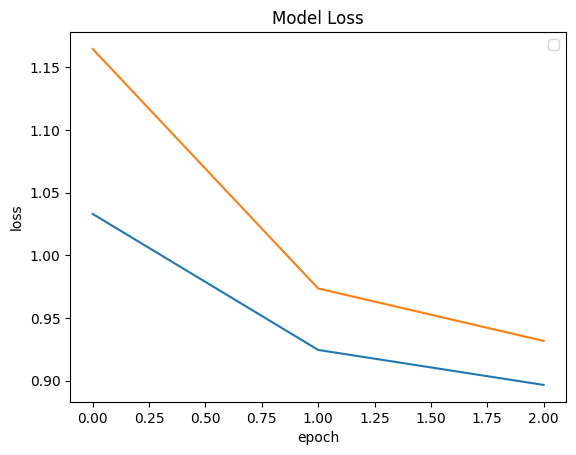

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

<ipython-input-78-e95d86a21908>:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train_accuracy', 'val_accuracy')


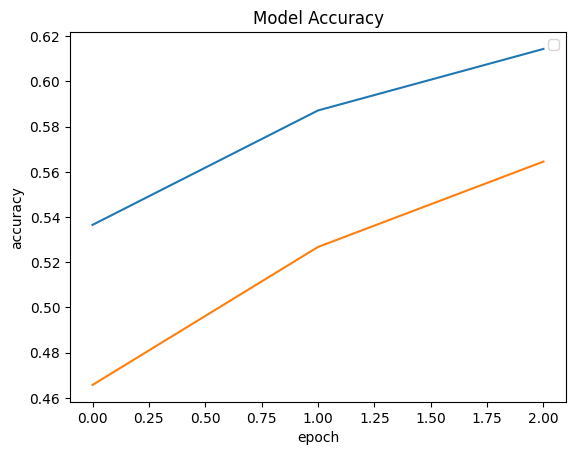

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 741ms/step - accuracy: 0.5728 - loss: 0.9181 - top_k_accuracy: 0.8515


[0.9316509962081909, 0.5645303130149841, 0.8555750846862793]

In [ ]:
test_img = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_rotation_2.jpg")
im = tf.constant(test_img, dtype= tf.float32)
im= tf.expand_dims(im, axis=0)
prediction = CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model(im), axis = -1).numpy()[0]]
print(prediction)

happy


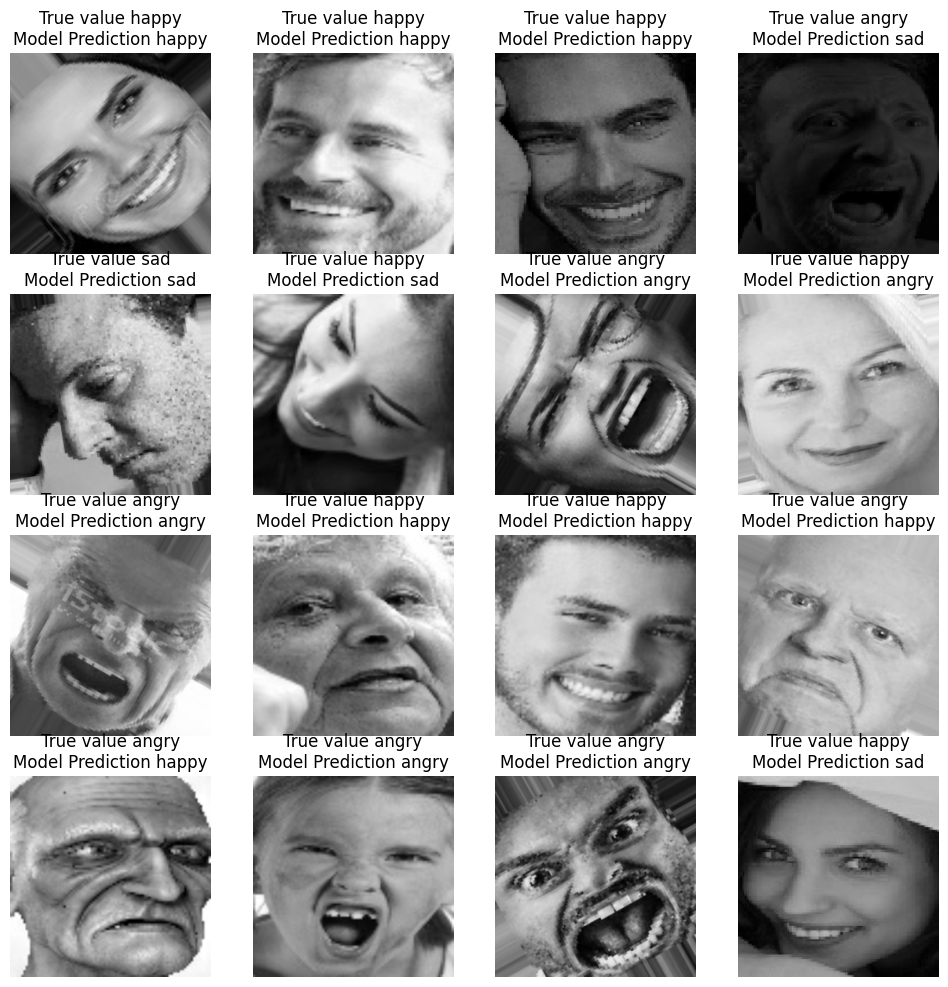

In [ ]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()]
    pred_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model(tf.expand_dims(images[i], axis=0)), axis = -1).numpy()[0]]
    plt.title("True value " + true_label + "\nModel Prediction " + pred_label)
    plt.axis("off")

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[222 156 137]
 [ 36 827 143]
 [ 47 197 513]]


Text(0.5, 58.7222222222222, 'Predicted')

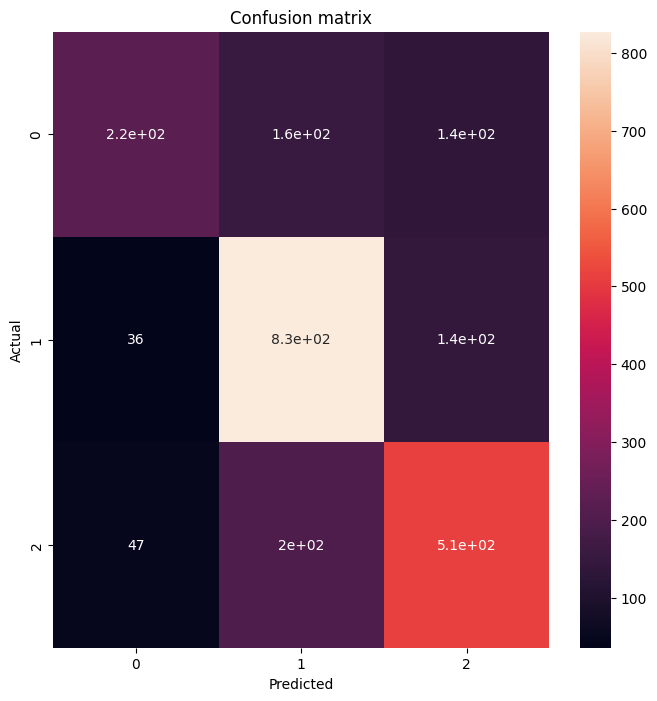

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ResNet - Via subclassing

In [41]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding='valid'):
    super(CustomConv2D, self).__init__(name='custom_conv2d')

    self.conv = Conv2D(
        filters=n_filters,
        kernel_size=kernel_size,
        activation='relu',
        strides=n_strides,
        padding=padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training=True):
    x = self.conv(x)
    x = self.batch_norm(x, training=training)
    return x


In [42]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides=1):
    super(ResidualBlock, self).__init__(name='res_block')

    self.dotted = (n_strides != 1)

    # First Conv layer with strides (for downsampling)
    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding="same")
    # Second Conv layer with stride of 1
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding="same")

    self.activation = Activation('relu')

    # If downsampling is required, add a 1x1 convolution
    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):
    x = self.custom_conv_1(input, training=training)
    x = self.custom_conv_2(x, training=training)

    # Apply skip connection
    if self.dotted:
      # Projection shortcut using 1x1 Conv if dimensions differ
      x_add = self.custom_conv_3(input, training=training)
      x_add = Add()([x, x_add])
    else:
      # Identity shortcut if dimensions are the same
      x_add = Add()([x, input])

    return self.activation(x_add)


In [43]:
class ResNet34(Model):
  def __init__(self):
    super(ResNet34, self).__init__(name='resnet_34')

    # Initial Conv Layer and Max Pooling
    self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
    self.max_pool = MaxPooling2D(3, 2)

    # Conv2_x: 3 Residual Blocks
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    # Conv3_x: 4 Residual Blocks (First Block with Stride 2 for Downsampling)
    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    # Conv4_x: 6 Residual Blocks (First Block with Stride 2 for Downsampling)
    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    # Conv5_x: 3 Residual Blocks (First Block with Stride 2 for Downsampling)
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    # Global Average Pooling and Fully Connected Layer
    self.global_pool = GlobalAveragePooling2D()
    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')

  def call(self, x, training=True):
    # Initial Conv and Pooling
    x = self.conv_1(x)
    x = self.max_pool(x)

    # Conv2_x
    x = self.conv_2_1(x, training=training)
    x = self.conv_2_2(x, training=training)
    x = self.conv_2_3(x, training=training)

    # Conv3_x
    x = self.conv_3_1(x, training=training)
    x = self.conv_3_2(x, training=training)
    x = self.conv_3_3(x, training=training)
    x = self.conv_3_4(x, training=training)

    # Conv4_x
    x = self.conv_4_1(x, training=training)
    x = self.conv_4_2(x, training=training)
    x = self.conv_4_3(x, training=training)
    x = self.conv_4_4(x, training=training)
    x = self.conv_4_5(x, training=training)
    x = self.conv_4_6(x, training=training)

    # Conv5_x
    x = self.conv_5_1(x, training=training)
    x = self.conv_5_2(x, training=training)
    x = self.conv_5_3(x, training=training)

    # Global Average Pooling and Output Layer
    x = self.global_pool(x)
    return self.fc_3(x)


In [46]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)         │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [47]:
# Setting checkpoints

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.keras',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [4]:
loss_function = CategoricalCrossentropy()

metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [50]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = resnet_34.fit(
    mixed_dataset.map(cutmix),
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/3
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.4097 - loss: 1.9547 - top_k_accuracy: 0.7403 
Epoch 1: val_accuracy improved from -inf to 0.39377, saving model to weights.01-1.26.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 5662s 26s/step - accuracy: 0.4098 - loss: 1.9521 - top_k_accuracy: 0.7404 - val_accuracy: 0.3938 - val_loss: 1.2557 - val_top_k_accuracy: 0.6962
Epoch 2/3
  3/213 ━━━━━━━━━━━━━━━━━━━━ 1:24:05 24s/step - accuracy: 0.4271 - loss: 1.1143 - top_k_accuracy: 0.7830

In [ ]:
resnet_34.evaluate(validation_dataset)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
test_img = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_rotation_2.jpg")
im = tf.constant(test_img, dtype= tf.float32)
im= tf.expand_dims(im, axis=0)
prediction = CONFIGURATION["CLASS_NAMES"][tf.argmax(resnet_34(im), axis = -1).numpy()[0]]
print(prediction)

In [ ]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()]
    pred_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(resnet_34(tf.expand_dims(images[i], axis=0)), axis = -1).numpy()[0]]
    plt.title("True value " + true_label + "\nModel Prediction " + pred_label)
    plt.axis("off")

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(resnet_34(im))
  labels.append(label.numpy())

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Mobile net v2


In [26]:
class DepthwiseSeparableConv(Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='same'):
        super(DepthwiseSeparableConv, self).__init__()

        self.depthwise = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding=padding)

        self.pointwise = Conv2D(filters, kernel_size=1, padding='same')
        self.batch_norm = BatchNormalization()
        self.activation = ReLU()

    def call(self, inputs, training=False):
        x = self.depthwise(inputs)
        x = self.pointwise(x)
        x = self.batch_norm(x, training=training)
        return self.activation(x)

# Inverted Residual Block (with Linear Bottleneck)
# Expands, applies depthwise conv, projects, then possibly adds a shortcut
class InvertedResidualBlock(Layer):
    def __init__(self, input_channels, output_channels, strides=1, expansion=6):
        super(InvertedResidualBlock, self).__init__()
        self.strides = strides

        # Expand phase: Increase channels by the expansion factor
        self.expand = Conv2D(input_channels * expansion, kernel_size=1, padding='same')
        self.expand_bn = BatchNormalization()
        self.expand_relu = ReLU()

        # Depthwise convolution
        self.depthwise = DepthwiseSeparableConv(input_channels * expansion, kernel_size=3, strides=strides)

        # Projection phase: Reduce channels to output channels
        self.project = Conv2D(output_channels, kernel_size=1, padding='same')
        self.project_bn = BatchNormalization()

        # Shortcut connection (if input and output shapes match)
        self.use_shortcut = (strides == 1 and input_channels == output_channels)

    def call(self, inputs, training=False):
        x = self.expand(inputs)
        x = self.expand_bn(x, training=training)
        x = self.expand_relu(x)

        x = self.depthwise(x, training=training)

        x = self.project(x)
        x = self.project_bn(x, training=training)

        # Add shortcut connection if applicable
        if self.use_shortcut:
            x = Add()([x, inputs])

        return x

# MobileNetV2 Model
class MobileNetV2(Model):
    def __init__(self, num_classes=3):
        super(MobileNetV2, self).__init__()

        # Initial Conv Layer
        self.conv_1 = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')
        self.bn_1 = BatchNormalization()

        # Inverted Residual Blocks
        self.block_1 = InvertedResidualBlock(32, 16, strides=1, expansion=1)
        self.block_2 = InvertedResidualBlock(16, 24, strides=2, expansion=6)
        self.block_3 = InvertedResidualBlock(24, 32, strides=1, expansion=6)
        self.block_4 = InvertedResidualBlock(32, 64, strides=2, expansion=6)
        self.block_5 = InvertedResidualBlock(64, 96, strides=1, expansion=6)
        self.block_6 = InvertedResidualBlock(96, 160, strides=2, expansion=6)
        self.block_7 = InvertedResidualBlock(160, 320, strides=1, expansion=6)

        self.conv_2 = Conv2D(1280, kernel_size=1, strides=1, padding='same', activation='relu')
        self.global_pool = GlobalAveragePooling2D()

        self.dropout = Dropout(0.3)

        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv_1(inputs)
        x = self.bn_1(x, training=training)

        x = self.block_1(x, training=training)
        x = self.block_2(x, training=training)
        x = self.block_3(x, training=training)
        x = self.block_4(x, training=training)
        x = self.block_5(x, training=training)
        x = self.block_6(x, training=training)
        x = self.block_7(x, training=training)

        x = self.conv_2(x)
        x = self.global_pool(x)
        x = self.dropout(x, training=training)

        x = self.fc(x)
        return x


In [27]:
mobilenet_v2_model = MobileNetV2(num_classes=3)
mobilenet_v2_model(tf.zeros([1, 256, 256, 3]), training=False)
mobilenet_v2_model.summary()

Model: "mobile_net_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (1, 128, 128, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (1, 128, 128, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inverted_residual_block              │ ?                           │           3,280 │
│ (InvertedResidualBlock)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inverted_residual_block_1            │ ?                           │          15,096 │
│ (InvertedResidualBlock)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inverted_residual_block_2            │ ?                           │          31,840 │
│ (InvertedResidualBlock)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inverted_residual_block_3            │ ?                           │          59,456 │
│ (InvertedResidualBlock)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inverted_residual_block_4            │ ?                           │         217,056 │
│ (InvertedResidualBlock)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inverted_residual_block_5            │ ?                           │         491,552 │
│ (InvertedResidualBlock)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inverted_residual_block_6            │ ?                           │       1,403,200 │
│ (InvertedResidualBlock)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (1, 16, 16, 1280)           │         410,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (1, 3)                      │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,637,227 (10.06 MB)

 Trainable params: 2,626,203 (10.02 MB)

 Non-trainable params: 11,024 (43.06 KB)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_mobilenet_v2.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]
loss_function = CategoricalCrossentropy()

metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [29]:
mobilenet_v2_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),
    loss = loss_function,
    metrics = metrics
)

In [31]:
history = mobilenet_v2_model.fit(
    mixed_dataset.map(cutmix),
    validation_data = validation_dataset,
    # epochs = CONFIGURATION["N_EPOCHS"],
    epochs = 10,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.4070 - loss: 1.3928 - top_k_accuracy: 0.7474
Epoch 1: val_accuracy improved from -inf to 0.43064, saving model to best_mobilenet_v2.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 192s 705ms/step - accuracy: 0.4071 - loss: 1.3919 - top_k_accuracy: 0.7475 - val_accuracy: 0.4306 - val_loss: 1.0661 - val_top_k_accuracy: 0.7713 - learning_rate: 0.0100
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4428 - loss: 1.0676 - top_k_accuracy: 0.7723
Epoch 2: val_accuracy improved from 0.43064 to 0.44205, saving model to best_mobilenet_v2.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 128s 597ms/step - accuracy: 0.4428 - loss: 1.0676 - top_k_accuracy: 0.7723 - val_accuracy: 0.4421 - val_loss: 1.0625 - val_top_k_accuracy: 0.7739 - learning_rate: 0.0100
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4502 - loss: 1.0580 - top_k_accuracy: 0.7830
Epoch 3: val_accuracy improved from 0.44205 to 0.44601, saving model to be

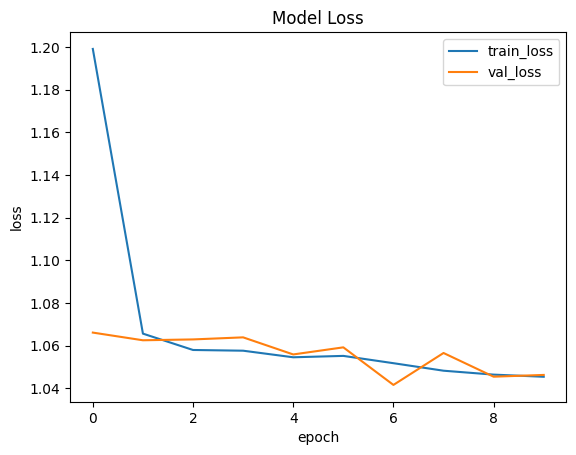

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

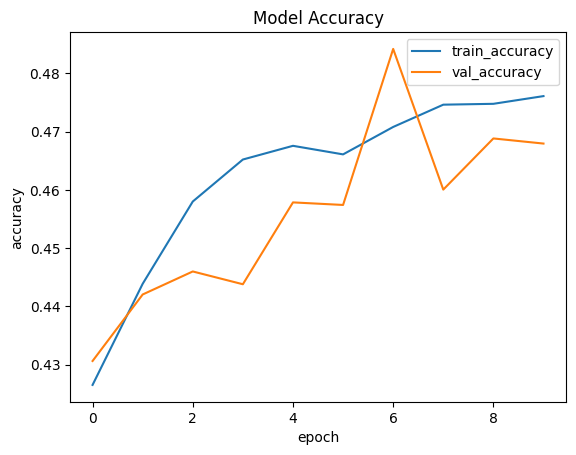

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [37]:
test_img = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_rotation_2.jpg")
im = tf.constant(test_img, dtype= tf.float32)
im= tf.expand_dims(im, axis=0)
prediction = CONFIGURATION["CLASS_NAMES"][tf.argmax(mobilenet_v2_model(im), axis = -1).numpy()[0]]
print(prediction)

happy


In [ ]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()]
    pred_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(mobilenet_v2_model(tf.expand_dims(images[i], axis=0)), axis = -1).numpy()[0]]
    plt.title("True value " + true_label + "\nModel Prediction " + pred_label)
    plt.axis("off")

In [39]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(mobilenet_v2_model(im))
  labels.append(label.numpy())

[[  0 461  54]
 [  0 958  48]
 [  2 610 145]]


Text(0.5, 58.7222222222222, 'Predicted')

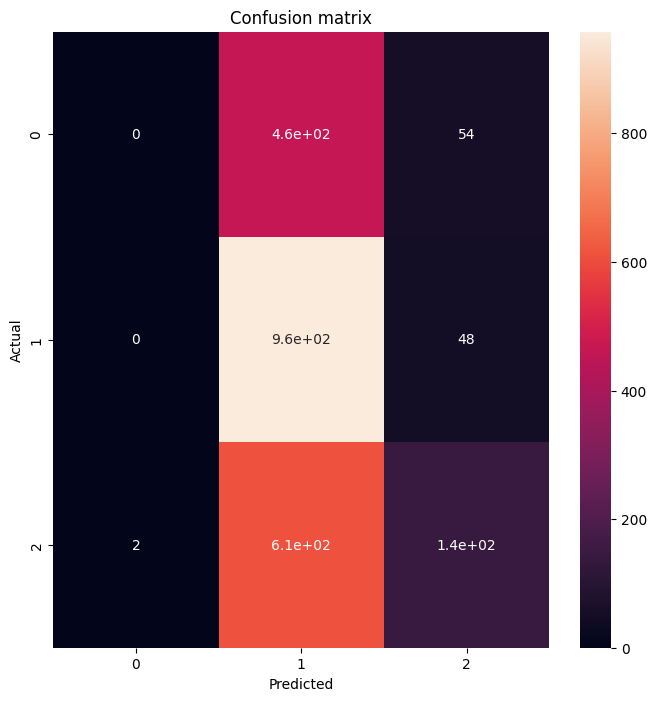

In [40]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Efficient net

In [14]:
# Swish Activation Function
class Swish(Layer):
    def call(self, inputs):
        return inputs * tf.nn.sigmoid(inputs)

# Squeeze and Excitation Block for Channel Attention
class SqueezeAndExcite(Layer):
    def __init__(self, input_channels, reduction=4):
        super(SqueezeAndExcite, self).__init__()
        self.global_pool = GlobalAveragePooling2D(keepdims=True)
        self.fc1 = Dense(input_channels // reduction, activation='relu')
        self.fc2 = Dense(input_channels, activation='sigmoid')

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        return Multiply()([inputs, x])

# MBConv Block (Mobile Inverted Bottleneck with Squeeze and Excite)
class MBConv(Layer):
    def __init__(self, input_channels, output_channels, strides=1, expansion=6, kernel_size=3, se_ratio=0.25):
        super(MBConv, self).__init__()
        self.strides = strides
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.expanded_channels = input_channels * expansion

        # Expansion Phase
        self.expand_conv = Conv2D(self.expanded_channels, kernel_size=1, padding='same', use_bias=False)
        self.expand_bn = BatchNormalization()
        self.expand_swish = Swish()

        # Depthwise Convolution
        self.depthwise_conv = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)
        self.depthwise_bn = BatchNormalization()
        self.depthwise_swish = Swish()

        # Squeeze and Excite
        self.se = SqueezeAndExcite(self.expanded_channels, reduction=int(1/se_ratio))

        # Output Projection
        self.project_conv = Conv2D(output_channels, kernel_size=1, padding='same', use_bias=False)
        self.project_bn = BatchNormalization()

        # Shortcut Connection (if input and output shapes match)
        self.use_shortcut = (strides == 1 and input_channels == output_channels)

    def call(self, inputs, training=False):
        x = self.expand_conv(inputs)
        x = self.expand_bn(x, training=training)
        x = self.expand_swish(x)

        x = self.depthwise_conv(x)
        x = self.depthwise_bn(x, training=training)
        x = self.depthwise_swish(x)

        x = self.se(x)

        x = self.project_conv(x)
        x = self.project_bn(x, training=training)

        # Add shortcut connection if applicable
        if self.use_shortcut:
            x = Add()([x, inputs])

        return x

# EfficientNet Model Implementation
class EfficientNet(Model):
    def __init__(self, num_classes=3):
        super(EfficientNet, self).__init__()

        # Initial Stem Layer
        self.stem_conv = Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)
        self.stem_bn = BatchNormalization()
        self.stem_swish = Swish()

        # MBConv Blocks (EfficientNetB0 Scaling)
        self.block_1 = MBConv(32, 16, strides=1, expansion=1)
        self.block_2 = MBConv(16, 24, strides=2, expansion=6)
        self.block_3 = MBConv(24, 40, strides=2, expansion=6)
        self.block_4 = MBConv(40, 80, strides=2, expansion=6)
        self.block_5 = MBConv(80, 112, strides=1, expansion=6)
        self.block_6 = MBConv(112, 192, strides=2, expansion=6)
        self.block_7 = MBConv(192, 320, strides=1, expansion=6)

        # Final Convolution and Pooling
        self.conv_head = Conv2D(1280, kernel_size=1, use_bias=False)
        self.bn_head = BatchNormalization()
        self.head_swish = Swish()
        self.global_pool = GlobalAveragePooling2D()

        # Dropout for regularization
        self.dropout = Dropout(0.3)

        # Fully connected layer for classification
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.stem_conv(inputs)
        x = self.stem_bn(x, training=training)
        x = self.stem_swish(x)

        x = self.block_1(x, training=training)
        x = self.block_2(x, training=training)
        x = self.block_3(x, training=training)
        x = self.block_4(x, training=training)
        x = self.block_5(x, training=training)
        x = self.block_6(x, training=training)
        x = self.block_7(x, training=training)

        x = self.conv_head(x)
        x = self.bn_head(x, training=training)
        x = self.head_swish(x)

        x = self.global_pool(x)
        x = self.dropout(x, training=training)

        x = self.fc(x)
        return x


In [15]:
efficient_net_model = EfficientNet(num_classes=3)
efficient_net_model(tf.zeros([1, 256, 256, 3]), training=False)
efficient_net_model.summary()

Model: "efficient_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (1, 128, 128, 32)           │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (1, 128, 128, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swish (Swish)                        │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mb_conv (MBConv)                     │ ?                           │           2,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mb_conv_1 (MBConv)                   │ ?                           │          10,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mb_conv_2 (MBConv)                   │ ?                           │          22,372 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mb_conv_3 (MBConv)                   │ ?                           │          62,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mb_conv_4 (MBConv)                   │ ?                           │         216,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mb_conv_5 (MBConv)                   │ ?                           │         443,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mb_conv_6 (MBConv)                   │ ?                           │       1,275,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (1, 8, 8, 1280)             │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (1, 8, 8, 1280)             │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swish_15 (Swish)                     │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (1, 3)                      │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,452,579 (9.36 MB)

 Trainable params: 2,437,123 (9.30 MB)

 Non-trainable params: 15,456 (60.38 KB)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_effcientnet_v2.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]
loss_function = CategoricalCrossentropy()

metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [18]:
efficient_net_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),
    loss = loss_function,
    metrics = metrics
)

In [19]:
history = efficient_net_model.fit(
    mixed_dataset.map(cutmix),
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = callbacks
)


Epoch 1/3
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.4140 - loss: 1.3569 - top_k_accuracy: 0.7342
Epoch 1: val_accuracy improved from -inf to 0.44162, saving model to best_effcientnet_v2.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 186s 686ms/step - accuracy: 0.4141 - loss: 1.3560 - top_k_accuracy: 0.7343 - val_accuracy: 0.4416 - val_loss: 1.0668 - val_top_k_accuracy: 0.7739 - learning_rate: 0.0100
Epoch 2/3
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4720 - loss: 1.0727 - top_k_accuracy: 0.7807
Epoch 2: val_accuracy did not improve from 0.44162
213/213 ━━━━━━━━━━━━━━━━━━━━ 122s 563ms/step - accuracy: 0.4720 - loss: 1.0727 - top_k_accuracy: 0.7807 - val_accuracy: 0.3573 - val_loss: 1.3564 - val_top_k_accuracy: 0.6857 - learning_rate: 0.0100
Epoch 3/3
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.4900 - loss: 1.0375 - top_k_accuracy: 0.7956
Epoch 3: val_accuracy did not improve from 0.44162
213/213 ━━━━━━━━━━━━━━━━━━━━ 140s 557ms/step - accuracy: 0.4899 - los

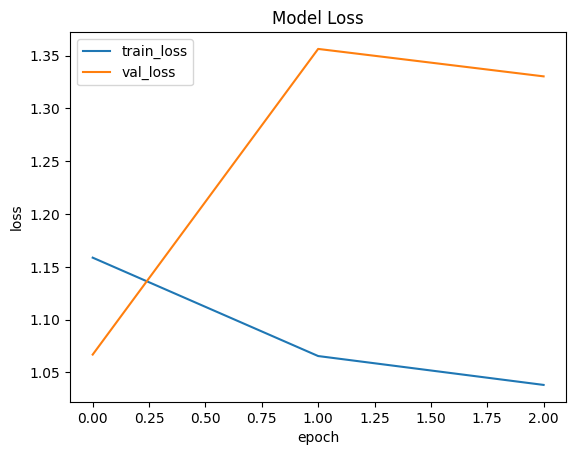

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

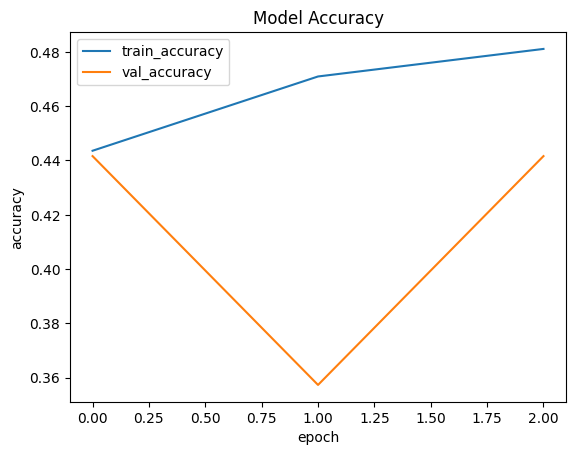

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [22]:
test_img = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_rotation_2.jpg")
im = tf.constant(test_img, dtype= tf.float32)
im= tf.expand_dims(im, axis=0)
prediction = CONFIGURATION["CLASS_NAMES"][tf.argmax(efficient_net_model(im), axis = -1).numpy()[0]]
print(prediction)

happy


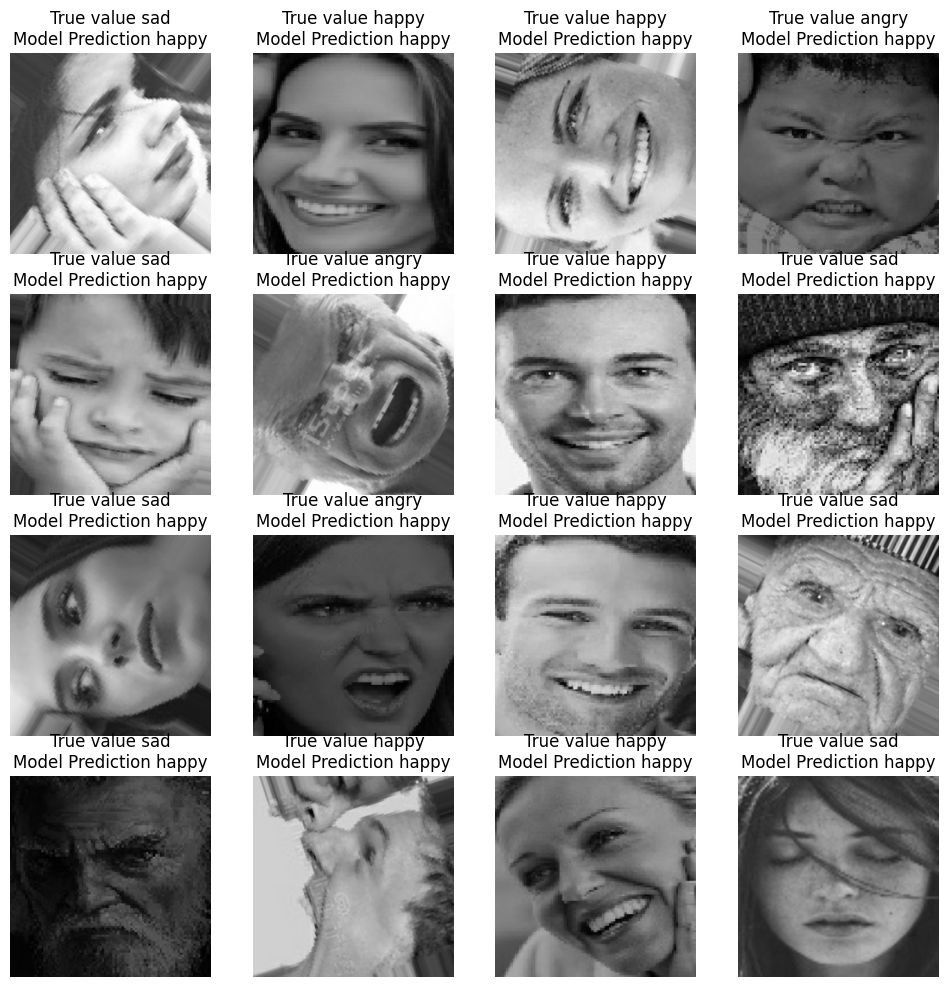

In [23]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()]
    pred_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(efficient_net_model(tf.expand_dims(images[i], axis=0)), axis = -1).numpy()[0]]
    plt.title("True value " + true_label + "\nModel Prediction " + pred_label)
    plt.axis("off")

In [24]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(efficient_net_model(im))
  labels.append(label.numpy())

[[   0  515    0]
 [   0 1006    0]
 [   0  757    0]]


Text(0.5, 58.7222222222222, 'Predicted')

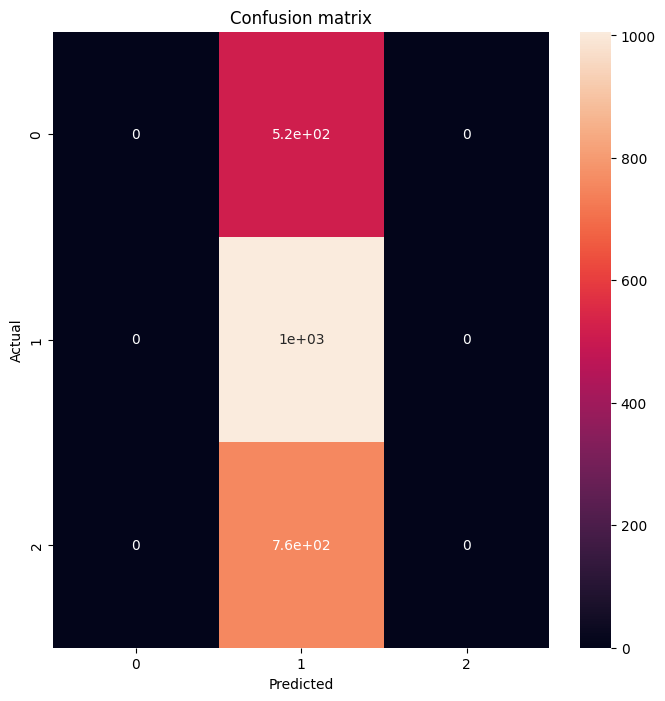

In [25]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')